<a href="https://colab.research.google.com/github/Just-Aymz/US-Insurance-Data/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**
___


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
from typing import Literal, Optional

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler,
    PowerTransformer
)
from scipy.stats import kurtosis, skew, shapiro
from scipy import stats

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

import pickle


# **Read Files**
___

In [2]:
# Clone the repository using the token for authentication
!git clone https://github.com/Just-Aymz/US-Insurance-Data.git

# Change to the directory
os.chdir('US-Insurance-Data')

fatal: destination path 'US-Insurance-Data' already exists and is not an empty directory.


In [3]:
# read in the dataset
df = pd.read_csv('insurance.csv')

# **Dataset Identification**
___

In [4]:
# Return the shape and size of the dataset
print(f'Shape of the dataset: {df.shape}\nSize of the dataset: {df.size}')

Shape of the dataset: (1338, 7)
Size of the dataset: 9366


In [5]:
# Return the axes of the dataset
df.axes

[RangeIndex(start=0, stop=1338, step=1),
 Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')]

In [6]:
# Return the datatypes of each feature
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


In [7]:
# Return an overview of the top 3 rows
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [8]:
# Return an overview of the last 3 rows
df.tail(3)

,age,sex,bmi,children,smoker,region,charges
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


# **Data Preprocessing**
___

## 1. **Data Cleaning**
___


In [9]:
def data_Cleaning(
    method: Literal['duplicates', 'nulls'],
    dataframe: Optional[pd.DataFrame]=df
) -> None:
  if method == 'duplicates':
    dupes = df.duplicated().sum()
    if dupes > 1:
      print(f'There are a total of {dupes} duplicates in the dataset')
    else:
      print('There are no duplicate values within the dataset')

  else:
    nulls = np.count_nonzero(df.isnull().values)
    if nulls > 1:
      print(f'There are a total of {dupes} null values in the dataset')
    else:
      print('There are no null values within the dataset')


### 1.1 **Duplicate Values**

In [10]:
data_Cleaning('duplicates')

There are no duplicate values within the dataset


### 1.2 **Null Values**

In [11]:
data_Cleaning('nulls')

There are no null values within the dataset


### 1.3 **Outlier Values**

In [12]:
def outlier_Values(feature: str, dataframe: Optional[pd.DataFrame]=df):
  # Store the q1 and q3 values
  q1 = dataframe[feature].quantile(0.25)
  q3 = dataframe[feature].quantile(0.75)

  # Find the IQR Value
  IQR = q3 - q1

  # Find the upper and lower limits for the outlier values
  upper = dataframe[feature] > q3 + (IQR * 1.5)
  lower = dataframe[feature] < q1 - (IQR * 1.5)

  # Store the total number of outliers in the feature
  outliers = dataframe[feature][upper | lower].index.tolist()

  if len(outliers) > 0:
    print(f'Column: {feature}\nOutliers: {len(outliers)}\n')
    return feature
  else:
    print(f'Column {feature} has no outliers\n')

In [13]:
outliers = []
for feature in df.select_dtypes(include='number'):
  outlier = outlier_Values(feature)
  if not isinstance(outlier, type(None)):
    outliers.append(outlier)

Column age has no outliers

Column: bmi
Outliers: 9

Column children has no outliers

Column: charges
Outliers: 139



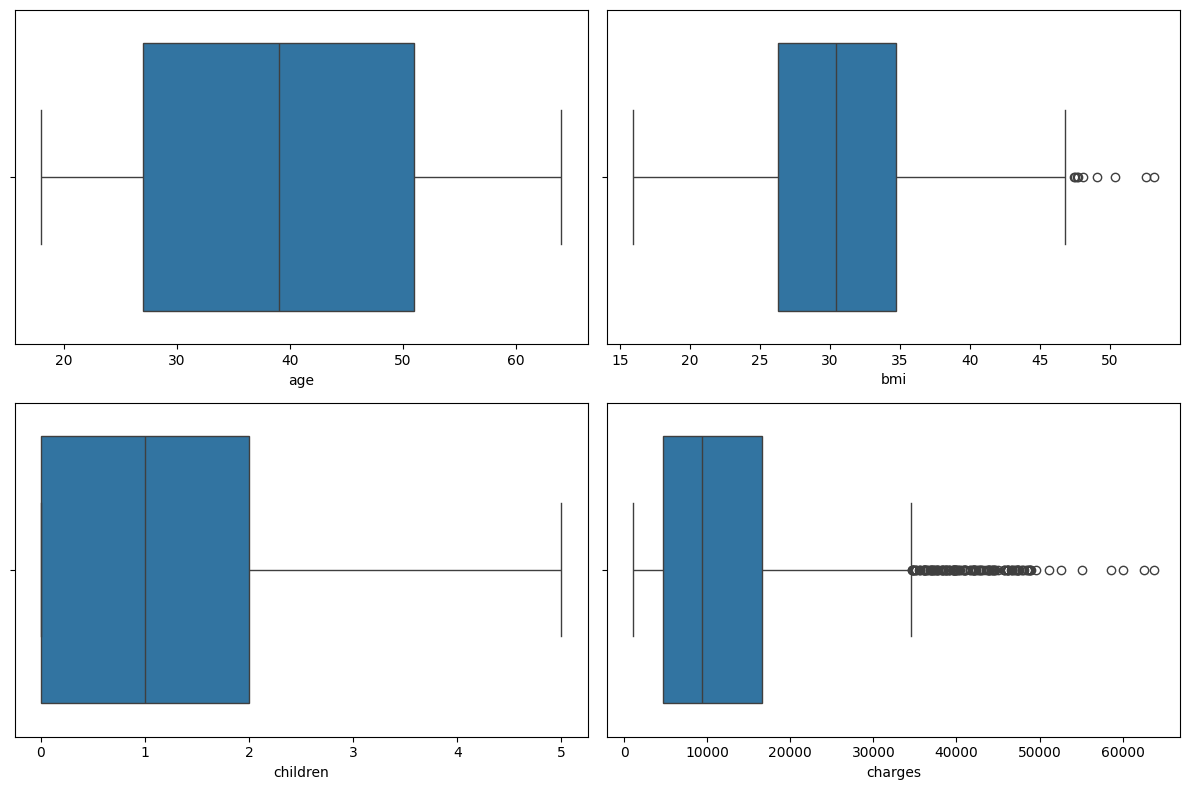

In [14]:
# Create the canvas whereby the plots will be placed
plt.figure(figsize=(12, 8))

# Iterate through the features
for i, column in enumerate(df.select_dtypes(include='number')):
  # Insert a subplot within the canvas
  plt.subplot(2, 2, i + 1)
  # Place a boxplot within the subplot
  sns.boxplot(data=df, x=column)

plt.tight_layout()
plt.show()

## 2. **Data Transformation**
___


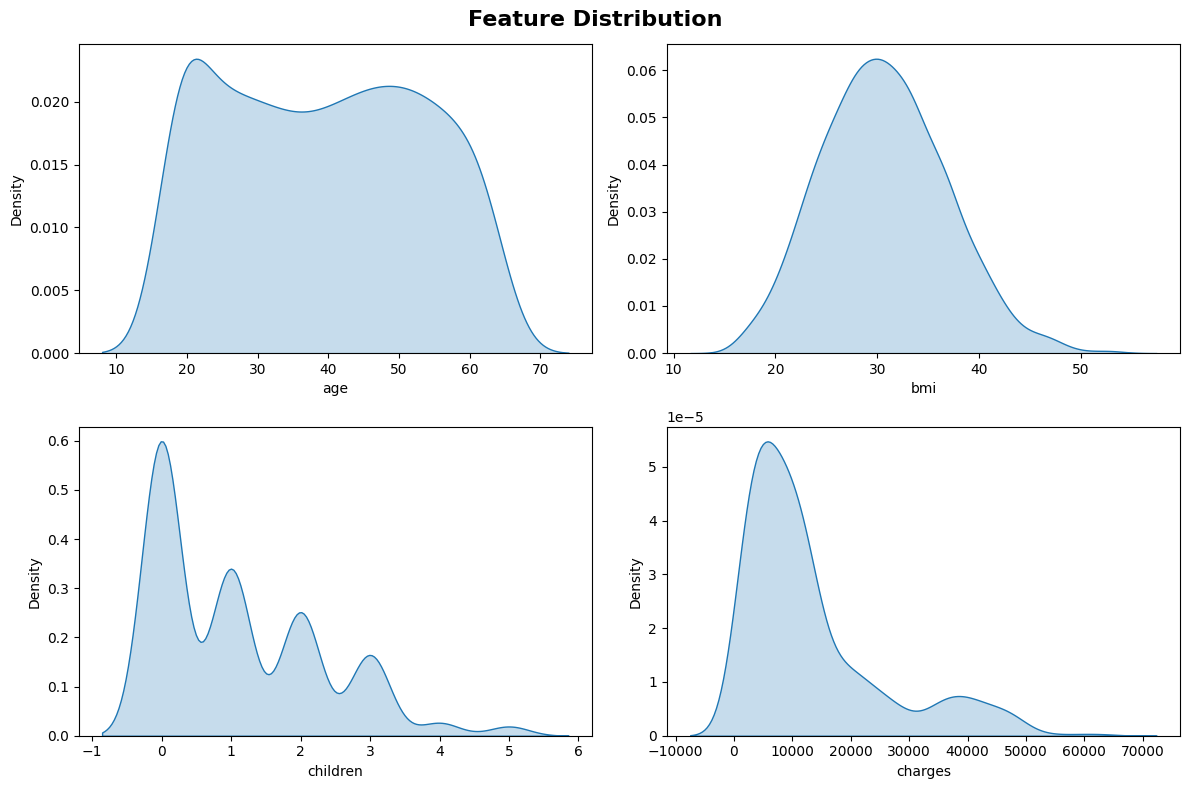

In [15]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(df.select_dtypes(include='number')):
  plt.subplot(2, 2, i + 1)
  sns.kdeplot(df[col], fill=True)
  plt.suptitle('Feature Distribution', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()

In [16]:
def statistics(dataframe: pd.DataFrame) -> None:
    """
    A function that outputs statistics for features with more than 12 unique
    values. The skew and Kurtosis values, along with the p-value from the
    Shapiro-Wilk test. These values help evaluate the distribution of the
    features of the dataframe passed in to the dataframe parameter.

    Args:
        dataframe:
            - A pandas dataframe object.

    Returns:
        None
    """
    for column in dataframe:
      _skew = skew(dataframe[column])
      _kurtosis = kurtosis(dataframe[column], fisher=True)
      print(
          f"\n{column}\n"
          f"skew: {_skew:.4f}\n"
          f"kurtosis: {_kurtosis:.4f}"
      )

      # Perform Shapiro-Wilk test
      stat, p_value = shapiro(dataframe[column])

      # Print the results
      print(f"KS Normality test: {stat:.4f}")
      print(f"P-value: {p_value:.4f}")

      # Interpret the p-value
      alpha = 0.05
      if p_value > alpha:
          print(
              "The data is likely normally distributed (fail to reject H0)."
          )
      else:
          print("The data is not normally distributed (reject H0).")

      # Check the absolute values of each skew value of a feature
      if np.abs(_skew) < 0.5:
          print('distribution is almost symmetrical')
      elif 0.5 <= np.abs(_skew) <= 1:
          print('distribution is modertely skewed')
      else:
          print('distribution is highly skewed')

statistics(df.select_dtypes(include='number'))


age
skew: 0.0556
kurtosis: -1.2449
KS Normality test: 0.9447
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is almost symmetrical

bmi
skew: 0.2837
kurtosis: -0.0550
KS Normality test: 0.9939
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is almost symmetrical

children
skew: 0.9373
kurtosis: 0.1972
KS Normality test: 0.8232
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is modertely skewed

charges
skew: 1.5142
kurtosis: 1.5958
KS Normality test: 0.8147
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is highly skewed


In [17]:
# Split into the dependent and independent variables
X = df.drop(columns='charges')
y = df.loc[:, 'charges']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Categorical Features
categorical_feats = (
    X.select_dtypes(exclude='number').columns.tolist() # Categorical features
)
categorical_transformer = OneHotEncoder(drop='first')

# Numeric Features
outlier_feats = outliers # Features with outliers
outlier_feats.remove('charges') # Remove target feature
robust_scaler = RobustScaler()

range_feats = ['children'] # Features with known range of values
normalization_scaler = MinMaxScaler()

gauss_feats = ['age'] # Features whose distribution is almost gaussian
standardization_scaler = StandardScaler()

# Use ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers = [
      ('onehot', categorical_transformer, categorical_feats),
      ('outlier_num', robust_scaler, outlier_feats),
      ('range_num', normalization_scaler, range_feats),
      ('std_num', standardization_scaler, gauss_feats)
    ]
)

# Fit and transform the independent variables using the preprocessed features.
X_transformed = preprocessor.fit_transform(X)

# Get the feature names for the transformed data
onehot_columns = (
    preprocessor.transformers_[0][1].get_feature_names_out(categorical_feats)
).tolist()

# Define the new column names for the transformed data
numeric_columns = (
    df.select_dtypes(include='number')
).columns.tolist()

# Remove target variable from the numeric features
numeric_columns.remove('charges')

all_columns = (
    onehot_columns + outlier_feats + range_feats + gauss_feats
)

# Return a scaled dataframe of the independent features
X_transformed_df = pd.DataFrame(X_transformed, columns=all_columns)
X_transformed_df.head()


,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi,children,age
0,0.0,1.0,0.0,0.0,1.0,-0.297708,0.0,-1.438764
1,1.0,0.0,0.0,1.0,0.0,0.401310,0.2,-1.509965
2,1.0,0.0,0.0,1.0,0.0,0.309616,0.6,-0.797954
3,1.0,0.0,1.0,0.0,0.0,-0.916344,0.0,-0.441948
4,1.0,0.0,1.0,0.0,0.0,-0.181006,0.0,-0.513149


In [18]:

# Create a pipeline to apply the transformations before applying each model
pipelines = {
    'gbr': Pipeline([
        ('preprocessor', preprocessor),
        ('gbr', GradientBoostingRegressor(random_state=42))
    ]),
    # 'xgb': Pipeline([
    #     ('preprocessor', preprocessor),
    #     ('xgb', XGBRegressor(random_state=42))
    # ]),
    'elasticnet': Pipeline([
        ('preprocessor', preprocessor),
        ('elasticnet', ElasticNet(random_state=42))
    ])
}

# Hyperparameter grids for each model
param_grids = {
    'gbr': {
      'gbr__n_estimators': [100, 200],
      'gbr__learning_rate': [0.01, 0.1, 0.2],
      'gbr__max_depth': [3, 5, 7]
    },
    'xgb': {
      'xgb__n_estimators': [100, 200],
      'xgb__learning_rate': [0.01, 0.1],
      'xgb__max_depth': [3, 5],
      'xgb__subsample': [0.8, 1.0],
      'xgb__colsample_bytree': [0.8, 1.0]
    },
    'elasticnet': {
      'elasticnet__alpha': [0.1, 0.5, 1.0, 5.0],
      'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
    }
}

# Fit and evaluate each model using GridSearchCV
results = {}
for model_name, pipeline in pipelines.items():
    print(f"Evaluating {model_name}...")

    grid_search = (
        GridSearchCV(
            pipeline, param_grids[model_name], cv=5, n_jobs=-1,
            scoring='neg_mean_squared_error'
        )
    )
    grid_search.fit(X_train, y_train)


    # Store results
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Compute RMSE

    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': best_model,
        'test_mse': mse,
        'test_rmse': rmse  # Store RMSE as well
    }

# Print out the best results for each model, including RMSE
for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Cross-Validation Score (MSE): {-result['best_score']}")
    print(f"Test Set Mean Squared Error (MSE): {result['test_mse']}")
    print(f"Test Set Root Mean Squared Error (RMSE): {result['test_rmse']}")

Evaluating gbr...
Evaluating elasticnet...

Model: gbr
Best Parameters: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 3, 'gbr__n_estimators': 100}
Best Cross-Validation Score (MSE): 23435596.76332338
Test Set Mean Squared Error (MSE): 19700570.21633455
Test Set Root Mean Squared Error (RMSE): 4438.532439482058

Model: elasticnet
Best Parameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Best Cross-Validation Score (MSE): 39602599.79713957
Test Set Mean Squared Error (MSE): 35397452.3726373
Test Set Root Mean Squared Error (RMSE): 5949.575814512939


In [ ]:
# Store the preprocesser as a pickle file
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Train the best model
model = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=100)
model.fit(X_train, y_train)

# Store the best model
with open('preprocessing/best_model.pkl', 'wb') as f:
    pickle.dump(model, f)